<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week7/PPG_ECG_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import os
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import butter, filtfilt

In [64]:
def analyze_patient_blood_pressure(file_path):
    """
    선택한 환자 파일의 혈압 데이터를 분석하고 시각화합니다.
    - 최대 2000개 세그먼트의 SBP, DBP 변동을 그래프로 표시합니다.
    - SBP, DBP 값의 분포를 히스토그램으로 보여주고, 권장 범위 충족 비율을 계산합니다.
    """
    print(f"'{file_path}' 파일 분석을 시작합니다...")

    try:
        with h5py.File(file_path, 'r') as f:
            if 'Subj_Wins' not in f or 'SegSBP' not in f['Subj_Wins']:
                print("오류: 파일이 유효한 PulseDB 형식이 아닙니다.")
                return

            # 1. 데이터 로딩 (최대 2000개 세그먼트)
            sbp_refs = f['Subj_Wins']['SegSBP'][0]
            dbp_refs = f['Subj_Wins']['SegDBP'][0]

            num_segments_to_load = min(len(sbp_refs), 2000)

            sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments_to_load]])
            dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments_to_load]])

            print(f"총 {num_segments_to_load}개의 세그먼트를 로드했습니다.")

            # 2. 요구사항: 전 구간 SBP, DBP 그래프 표시
            print("\n요구사항 1: 전체 혈압 변동 그래프를 생성합니다...")
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(18, 7))
            plt.plot(sbps, label='SBP (Systolic)', color='red', alpha=0.8, linewidth=1.5)
            plt.plot(dbps, label='DBP (Diastolic)', color='blue', alpha=0.8, linewidth=1.5)
            plt.title(f'Blood Pressure Trend for Patient ({os.path.basename(file_path)})', fontsize=16)
            plt.xlabel('Segment Index', fontsize=12)
            plt.ylabel('Blood Pressure (mmHg)', fontsize=12)
            plt.legend() # <--- FIX 2: 그래프에 범례를 추가합니다.
            plt.show()

            # 3. 요구사항: 혈압 범위 적합성 분석 및 시각화
            print("\n요구사항 2: 혈압 범위 적합성을 분석합니다...")
            avg_sbp = np.mean(sbps)
            avg_dbp = np.mean(dbps)

            # 정상 SBP (90 <= sbp < 130) 비율 계산
            sbp_in_range_pct = np.mean((sbps >= 90) & (sbps < 130)) * 100
            # 정상 DBP (60 <= dbp < 80) 비율 계산
            dbp_in_range_pct = np.mean((dbps >= 60) & (dbps < 80)) * 100

            print("\n--- 혈압 통계 요약 ---")
            print(f"  - 평균 SBP: {avg_sbp:.2f} mmHg")
            print(f"  - 평균 DBP: {avg_dbp:.2f} mmHg")
            print(f"  - 정상 SBP (90-130) 비율: {sbp_in_range_pct:.2f}%")
            print(f"  - 정상 DBP (60-80) 비율: {dbp_in_range_pct:.2f}%")

            # 히스토그램 시각화
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
            fig.suptitle('Blood Pressure Distribution Analysis', fontsize=16)

            ax1.hist(sbps, bins=30, color='coral', edgecolor='black')
            ax1.axvline(90, color='darkgreen', linestyle='--', label='Normal lower bound (90)')
            ax1.axvline(130, color='darkred', linestyle='--', label='Normal upper bound (130)')
            ax1.set_title('SBP Distribution')
            ax1.set_xlabel('SBP (mmHg)')
            ax1.legend()

            ax2.hist(dbps, bins=30, color='skyblue', edgecolor='black')
            ax2.axvline(60, color='darkgreen', linestyle='--', label='Normal lower bound (60)')
            ax2.axvline(80, color='darkred', linestyle='--', label='Normal upper bound (80)')
            ax2.set_title('DBP Distribution')
            ax2.set_xlabel('DBP (mmHg)')
            ax2.legend()

            plt.show()

            # 최종 추천
            print("\n--- 최종 분석 결과 ---")
            if sbp_in_range_pct > 70 and dbp_in_range_pct > 70:
                print("✅ 이 환자는 정상 혈압 범위 조건을 잘 만족하는 훌륭한 후보입니다.")
            elif sbp_in_range_pct > 50 and dbp_in_range_pct > 50:
                print("⚠️ 이 환자는 어느 정도 조건을 만족하지만, 일부 혈압이 범위를 벗어납니다. 사용 가능합니다.")
            else:
                print("❌ 이 환자는 정상 혈압 범위와 차이가 커 보입니다. 다른 환자를 찾아보는 것을 고려해 보세요.")

    except FileNotFoundError:
        print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    except Exception as e:
        print(f"파일 분석 중 오류가 발생했습니다: {e}")

'/content/drive/MyDrive/Colab Notebooks/p001331.mat' 파일 분석을 시작합니다...
총 2000개의 세그먼트를 로드했습니다.

요구사항 1: 전체 혈압 변동 그래프를 생성합니다...


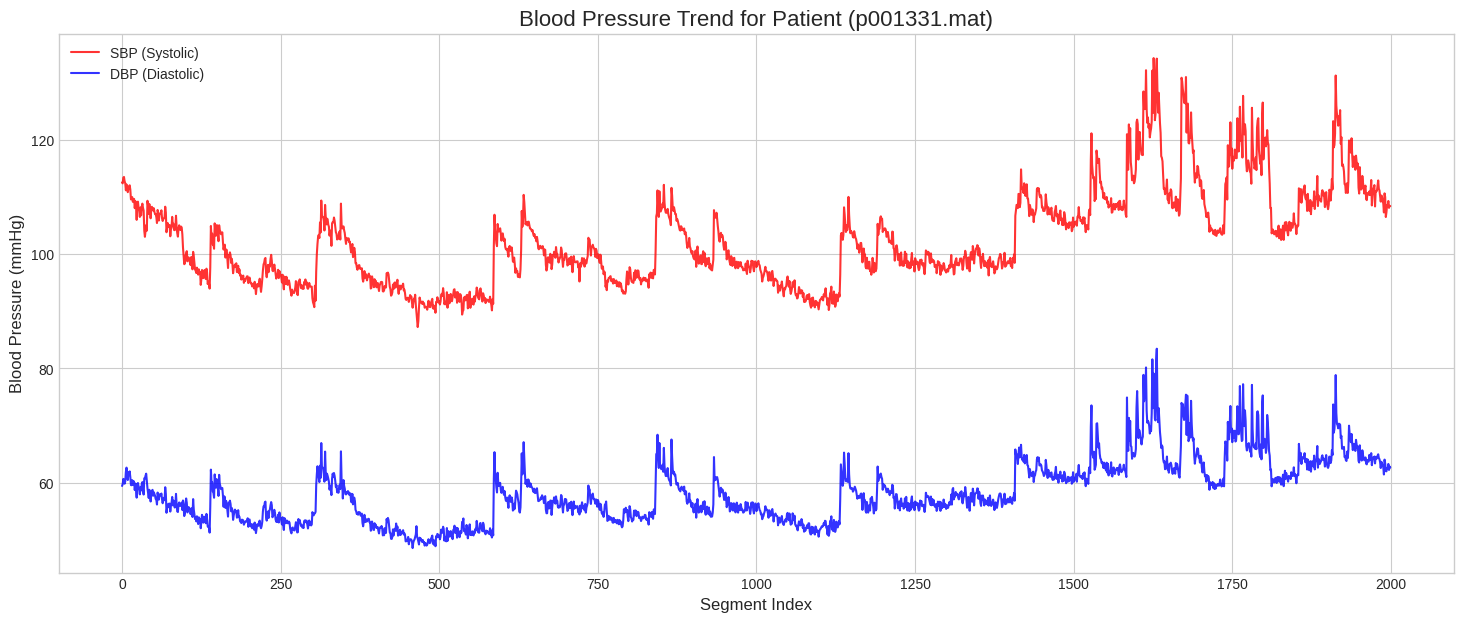


요구사항 2: 혈압 범위 적합성을 분석합니다...

--- 혈압 통계 요약 ---
  - 평균 SBP: 102.52 mmHg
  - 평균 DBP: 58.30 mmHg
  - 정상 SBP (90-130) 비율: 99.15%
  - 정상 DBP (60-80) 비율: 34.40%


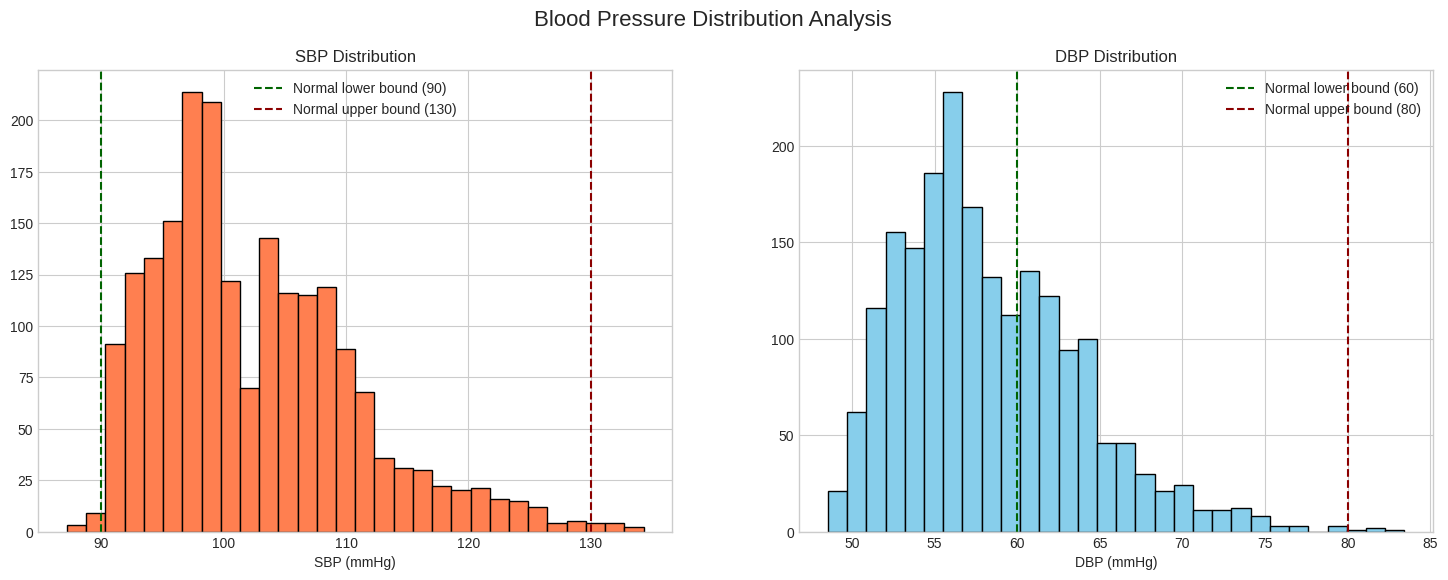


--- 최종 분석 결과 ---
❌ 이 환자는 정상 혈압 범위와 차이가 커 보입니다. 다른 환자를 찾아보는 것을 고려해 보세요.


In [65]:
# ===== 실행 부분 =====
# 1. 다운로드한 환자 .mat 파일의 전체 경로를 여기에 입력하세요.
# 예시: PATIENT_FILE_PATH = '/content/PulseDB_MIMIC/p012345.mat'
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat' # 여기에 본인의 파일 경로를 입력

# 2. 분석 함수 실행
analyze_patient_blood_pressure(PATIENT_FILE_PATH)

'/content/drive/MyDrive/Colab Notebooks/p001331.mat' 파일의 Fold별 데이터 분포 분석을 시작합니다...

각 Fold별 혈압 통계:
--------------------------------------------------
Fold  | SBP Mean   | SBP Std    | DBP Mean   | DBP Std   
--------------------------------------------------
Fold 1  | 100.45     | 5.29       | 56.07      | 3.12      
Fold 2  | 96.26      | 4.39       | 54.06      | 3.39      
Fold 3  | 98.59      | 4.92       | 56.06      | 3.33      
Fold 4  | 103.84     | 5.78       | 59.76      | 3.55      
Fold 5  | 113.46     | 7.14       | 65.56      | 4.44      
--------------------------------------------------


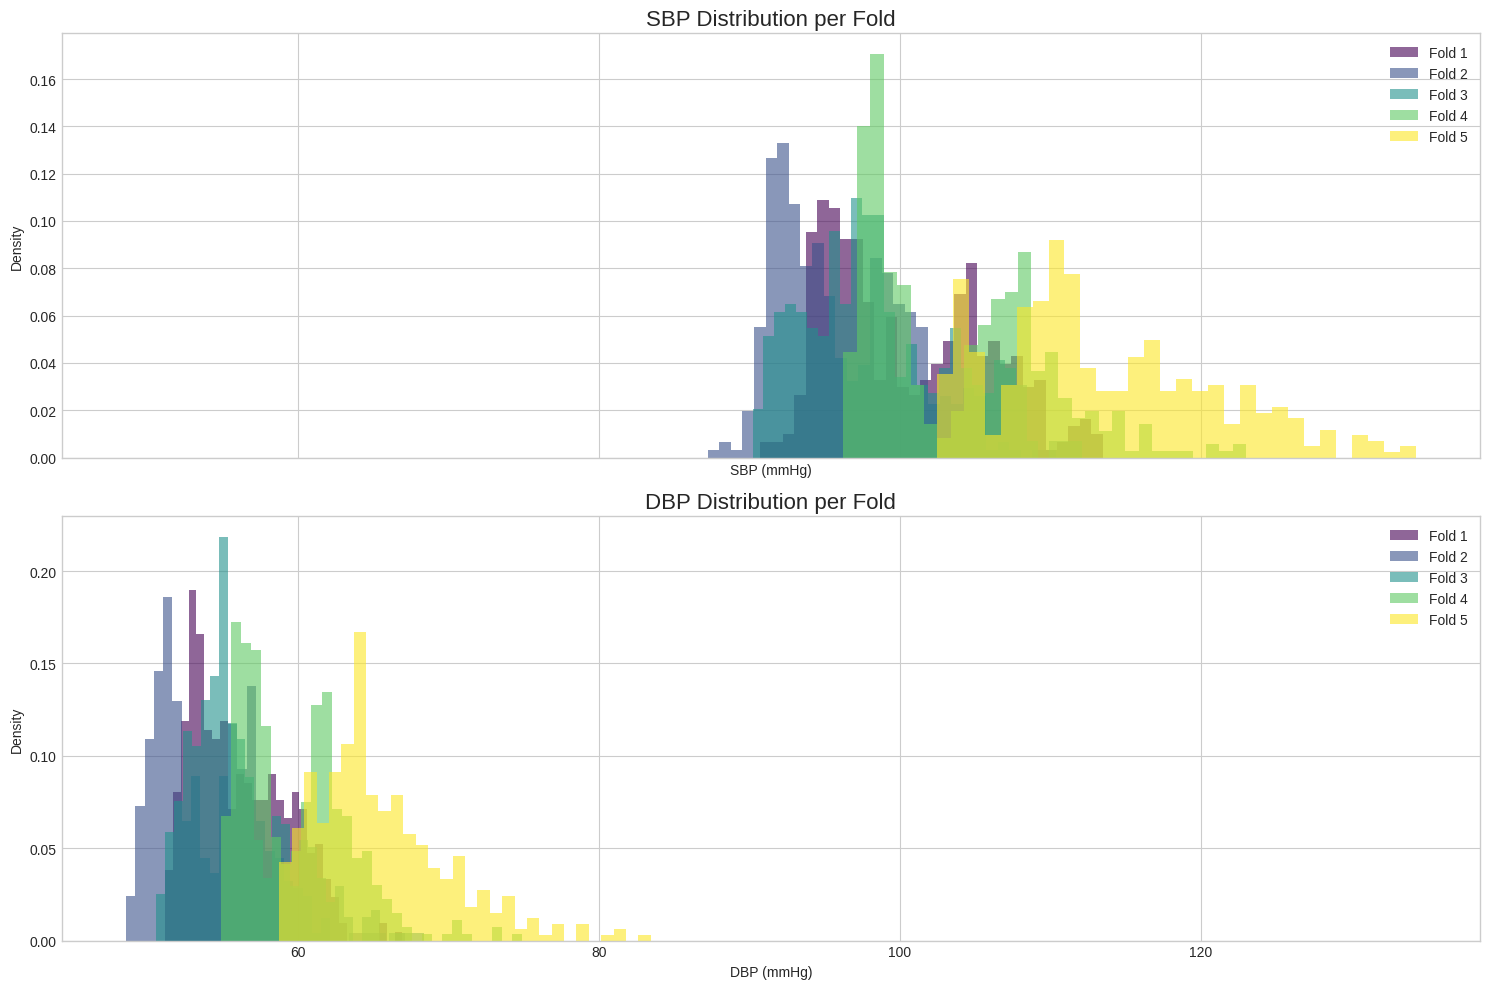

In [66]:
# ===== 설정 =====
# 분석할 환자 .mat 파일의 경로를 지정하세요.
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat'

def analyze_fold_distribution(file_path):
    """
    환자 데이터를 5-Fold로 나누어 각 Fold별 SBP, DBP 분포를 시각화합니다.
    """
    print(f"'{file_path}' 파일의 Fold별 데이터 분포 분석을 시작합니다...")

    try:
        with h5py.File(file_path, 'r') as f:
            if 'Subj_Wins' not in f or 'SegSBP' not in f['Subj_Wins']:
                print("오류: 파일이 유효한 PulseDB 형식이 아닙니다.")
                return

            sbp_refs = f['Subj_Wins']['SegSBP'][0]
            dbp_refs = f['Subj_Wins']['SegDBP'][0]

            num_segments_to_load = min(len(sbp_refs), 2000)
            if num_segments_to_load < 2000:
                print(f"경고: 세그먼트 수가 {num_segments_to_load}개로 2000개 미만입니다.")
                return

            sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments_to_load]])
            dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments_to_load]])

            n_splits = 5
            fold_size = 400

            # SBP, DBP 분포를 그릴 준비
            fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
            colors = plt.cm.viridis(np.linspace(0, 1, n_splits))

            print("\n각 Fold별 혈압 통계:")
            print("-" * 50)
            print(f"{'Fold':<5} | {'SBP Mean':<10} | {'SBP Std':<10} | {'DBP Mean':<10} | {'DBP Std':<10}")
            print("-" * 50)

            for i in range(n_splits):
                fold_start = i * fold_size
                fold_end = fold_start + fold_size

                sbp_fold = sbps[fold_start:fold_end]
                dbp_fold = dbps[fold_start:fold_end]

                # 통계 출력
                print(f"Fold {i+1:<2} | {np.mean(sbp_fold):<10.2f} | {np.std(sbp_fold):<10.2f} | {np.mean(dbp_fold):<10.2f} | {np.std(dbp_fold):<10.2f}")

                # 히스토그램 그리기 (밀도 플롯)
                axes[0].hist(sbp_fold, bins=30, density=True, color=colors[i], alpha=0.6, label=f'Fold {i+1}')
                axes[1].hist(dbp_fold, bins=30, density=True, color=colors[i], alpha=0.6, label=f'Fold {i+1}')

            print("-" * 50)

            axes[0].set_title('SBP Distribution per Fold', fontsize=16)
            axes[0].set_xlabel('SBP (mmHg)')
            axes[0].set_ylabel('Density')
            axes[0].legend()

            axes[1].set_title('DBP Distribution per Fold', fontsize=16)
            axes[1].set_xlabel('DBP (mmHg)')
            axes[1].set_ylabel('Density')
            axes[1].legend()

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"파일 분석 중 오류가 발생했습니다: {e}")


# ===== 실행 부분 =====
analyze_fold_distribution(PATIENT_FILE_PATH)

In [73]:
# ===================================================================
# 1. 설정 (Configuration)
# ===================================================================
# 분석할 환자 .mat 파일의 전체 경로를 지정하세요.
PATIENT_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/p001331.mat'

# 실험 모드를 선택하세요: 'PPG_ONLY' 또는 'PPG_ECG'
MODE = 'PPG_ECG'

# 모델 아키텍처 선택: 'CNN_ONLY', 'CNN_LSTM_ATTENTION', 또는 'CNN_TRANSFORMER'
MODEL_ARCHITECTURE = 'CNN_TRANSFORMER'

# Bandpass 필터링 적용 여부
APPLY_BANDPASS_FILTER = False

# ===== 안정성 향상을 위한 추가 설정 =====
USE_BATCH_NORM = True
APPLY_AUGMENTATION = False
WEIGHT_DECAY = 1e-4
USE_LR_SCHEDULER = True
GRADIENT_CLIPPING_VALUE = 1.0

# 하이퍼파라미터
NUM_EPOCHS = 60
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SAMPLING_RATE = 125

# ===== 트랜스포머 고급 설정 (성능 향상용) =====
D_MODEL = 128
N_HEAD = 8
NUM_LAYERS = 3

## PPG + ECG로 예측하는 것은 PPG 단독으로 할 때보다 트랜스포머의 파라미터를 늘렸더니 성능이 올라감,
### PPG에 했던 하이퍼파라미터 설정을 그대로 했을 땐 성능이 떨어짐.

In [74]:
# ===================================================================
# 2. 데이터 로딩 및 전처리 함수 (동일)
# ===================================================================
def apply_bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=SAMPLING_RATE, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def augment_signal(signal, noise_factor=0.02):
    noise = np.random.normal(0, np.std(signal) * noise_factor, signal.shape)
    return signal + noise

def load_bp_data(file_path, mode='PPG_ONLY', apply_filter=False):
    print(f"'{mode}' 모드로 데이터 로딩을 시작합니다...")
    with h5py.File(file_path, 'r') as f:
        sbp_refs, dbp_refs, ppg_refs = f['Subj_Wins']['SegSBP'][0], f['Subj_Wins']['SegDBP'][0], f['Subj_Wins']['PPG_F'][0]
        num_segments = min(len(sbp_refs), 2000)
        if num_segments < 2000:
            raise ValueError(f"오류: 환자 파일에 {num_segments}개의 세그먼트만 있습니다. 최소 2000개가 필요합니다.")

        sbps = np.array([float(f[ref][()][0, 0]) for ref in sbp_refs[:num_segments]], dtype=np.float32)
        dbps = np.array([float(f[ref][()][0, 0]) for ref in dbp_refs[:num_segments]], dtype=np.float32)
        ppgs = np.array([f[ref][()].squeeze().astype(np.float32) for ref in ppg_refs[:num_segments]])
        Y = np.vstack([sbps, dbps]).T

        if apply_filter:
            print("신호에 Bandpass 필터를 적용합니다...")
            ppgs = np.array([apply_bandpass_filter(s) for s in ppgs])

        if mode == 'PPG_ONLY':
            X = np.expand_dims(ppgs, axis=1)
        elif mode == 'PPG_ECG':
            ecg_refs = f['Subj_Wins']['ECG_F'][0]
            ecgs = np.array([f[ref][()].squeeze().astype(np.float32) for ref in ecg_refs[:num_segments]])
            if apply_filter:
                ecgs = np.array([apply_bandpass_filter(s) for s in ecgs])
            X = np.stack([ppgs, ecgs], axis=1)
        else:
            raise ValueError("Mode는 'PPG_ONLY' 또는 'PPG_ECG' 여야 합니다.")

    print(f"데이터 로딩 완료: X 형태={X.shape}, Y 형태={Y.shape}")
    return X, Y

In [75]:
# ===================================================================
# 3. 모델 정의 (트랜스포머 모델 추가)
# ===================================================================
class Conv1DNet(nn.Module):
    def __init__(self, input_channels=1, use_batch_norm=True):
        super(Conv1DNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, 7, padding=3),
            nn.BatchNorm1d(32) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(64, 128, 3, padding=1),
            nn.BatchNorm1d(128) if use_batch_norm else nn.Identity(),
            nn.ReLU()
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_block = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 2))
    def forward(self, x):
        x = self.cnn_extractor(x)
        x = self.global_pool(x).view(x.size(0), -1)
        return self.fc_block(x)

class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_layer = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.Tanh(),
            nn.Linear(feature_dim, 1)
        )

    def forward(self, x):
        attention_weights = self.attention_layer(x)
        attention_weights = F.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * x, dim=1)
        return context_vector

class Conv1DLSTMNet(nn.Module):
    def __init__(self, input_channels=1, lstm_hidden_size=64, use_batch_norm=True):
        super(Conv1DLSTMNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(input_channels, 32, 7, padding=3),
            nn.BatchNorm1d(32) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        self.lstm = nn.LSTM(64, lstm_hidden_size, 1, batch_first=True, bidirectional=True)
        self.attention = Attention(lstm_hidden_size * 2)
        self.fc_block = nn.Sequential(nn.Linear(lstm_hidden_size * 2, 64), nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 2))
    def forward(self, x):
        x = self.cnn_extractor(x).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        context_vector = self.attention(lstm_out)
        return self.fc_block(context_vector)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class PositionalEncoding(nn.Module):
    # ... (생략)
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class ConvTransformerNet(nn.Module):
    def __init__(self, input_channels=1, d_model=64, nhead=4, num_layers=2, use_batch_norm=True):
        super(ConvTransformerNet, self).__init__()
        # CNN extractor: d_model에 맞춰 채널 수 조절
        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(input_channels, d_model // 2, 7, padding=3),
            nn.BatchNorm1d(d_model // 2) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(d_model // 2, d_model, 5, padding=2),
            nn.BatchNorm1d(d_model) if use_batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*2, dropout=0.4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc_block = nn.Sequential(nn.Linear(d_model, 64), nn.ReLU(), nn.Dropout(0.5), nn.Linear(64, 2))
        self.d_model = d_model

    def forward(self, x):
        x = self.cnn_extractor(x).permute(0, 2, 1)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc_block(x)

In [76]:
# ===================================================================
# 4. 유틸리티 및 시각화 함수 (동일)
# ===================================================================
def plot_learning_curves(history, fold_num):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num} - Learning Curves (Loss over Epochs)')
    plt.xlabel('Epoch'), plt.ylabel('MAE Loss'), plt.legend(), plt.grid(True)
    plt.show()

def plot_overall_regression_results(y_true, y_pred, patient_id):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Overall Model Performance for Patient {patient_id} (All Folds Combined)', fontsize=16)

    # SBP
    sbp_true, sbp_pred = y_true[:, 0], y_pred[:, 0]
    axes[0, 0].scatter(sbp_true, sbp_pred, alpha=0.5, c='royalblue')
    axes[0, 0].plot([min(sbp_true), max(sbp_true)], [min(sbp_true), max(sbp_true)], 'r--', label='y=x')
    axes[0, 0].set_title('SBP: Predicted vs. Actual'), axes[0, 0].set_xlabel('Actual SBP'), axes[0, 0].set_ylabel('Predicted SBP'), axes[0, 0].grid(True), axes[0, 0].legend()

    sbp_residuals = sbp_true - sbp_pred
    axes[0, 1].scatter(sbp_pred, sbp_residuals, alpha=0.5, c='coral')
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_title('SBP: Residuals vs. Predicted'), axes[0, 1].set_xlabel('Predicted SBP'), axes[0, 1].set_ylabel('Residuals'), axes[0, 1].grid(True)

    # DBP
    dbp_true, dbp_pred = y_true[:, 1], y_pred[:, 1]
    axes[1, 0].scatter(dbp_true, dbp_pred, alpha=0.5, c='mediumseagreen')
    axes[1, 0].plot([min(dbp_true), max(dbp_true)], [min(dbp_true), max(dbp_true)], 'r--', label='y=x')
    axes[1, 0].set_title('DBP: Predicted vs. Actual'), axes[1, 0].set_xlabel('Actual DBP'), axes[1, 0].set_ylabel('Predicted DBP'), axes[1, 0].grid(True), axes[1, 0].legend()

    dbp_residuals = dbp_true - dbp_pred
    axes[1, 1].scatter(dbp_pred, dbp_residuals, alpha=0.5, c='orchid')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_title('DBP: Residuals vs. Predicted'), axes[1, 1].set_xlabel('Predicted DBP'), axes[1, 1].set_ylabel('Residuals'), axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Using device: cuda
'PPG_ECG' 모드로 데이터 로딩을 시작합니다...
데이터 로딩 완료: X 형태=(2000, 2, 1250), Y 형태=(2000, 2)

===== Fold 1/5 Start =====
선택된 모델: CNN_TRANSFORMER (Batch Norm: True)


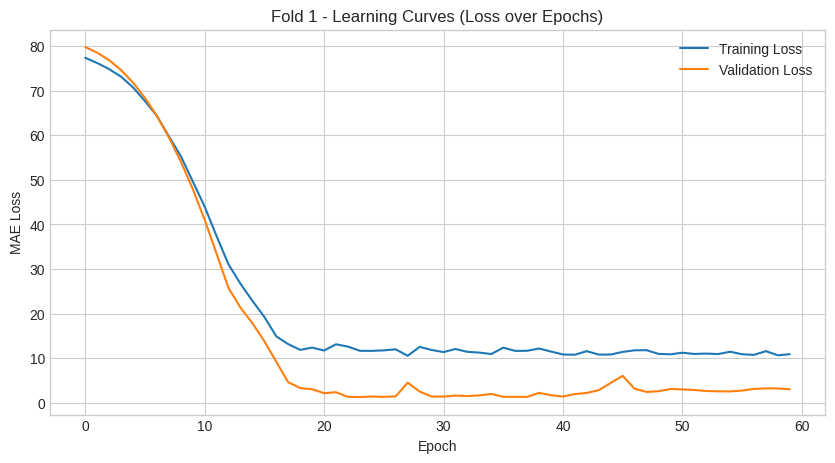

Fold 1 Result -> SBP MAE: 2.65, RMSE: 3.42 | DBP MAE: 1.84, RMSE: 2.17

===== Fold 2/5 Start =====
선택된 모델: CNN_TRANSFORMER (Batch Norm: True)


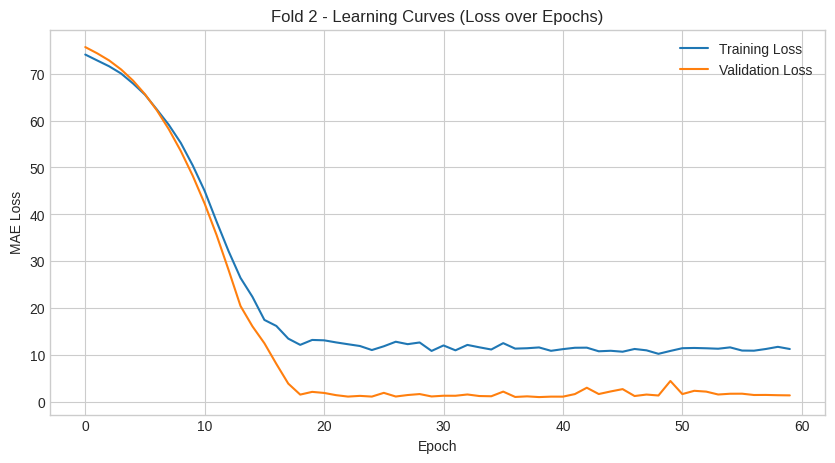

Fold 2 Result -> SBP MAE: 2.77, RMSE: 3.36 | DBP MAE: 1.49, RMSE: 1.78

===== Fold 3/5 Start =====
선택된 모델: CNN_TRANSFORMER (Batch Norm: True)


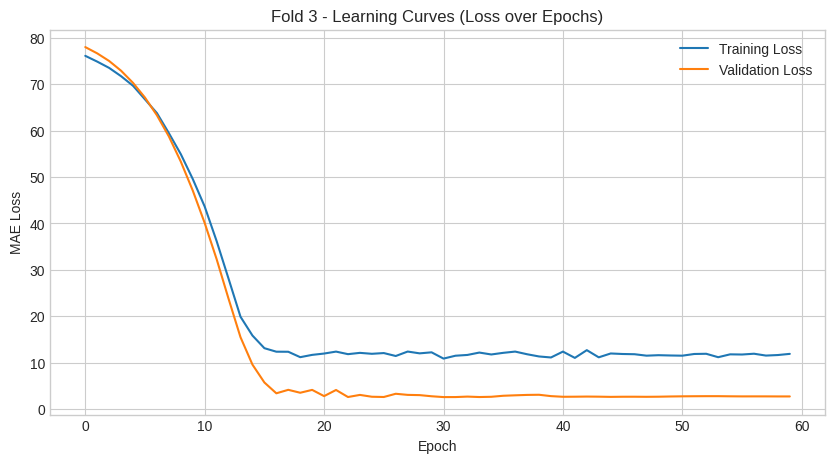

Fold 3 Result -> SBP MAE: 3.21, RMSE: 3.57 | DBP MAE: 1.89, RMSE: 2.22

===== Fold 4/5 Start =====
선택된 모델: CNN_TRANSFORMER (Batch Norm: True)


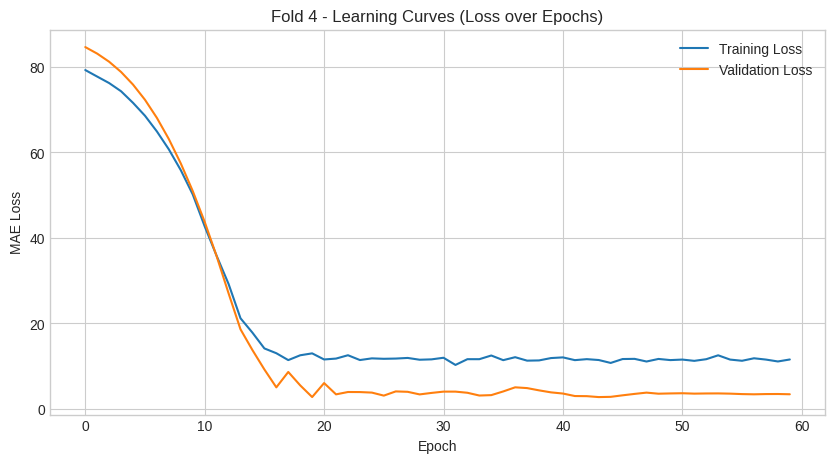

Fold 4 Result -> SBP MAE: 5.63, RMSE: 7.31 | DBP MAE: 3.23, RMSE: 4.60

===== Fold 5/5 Start =====
선택된 모델: CNN_TRANSFORMER (Batch Norm: True)


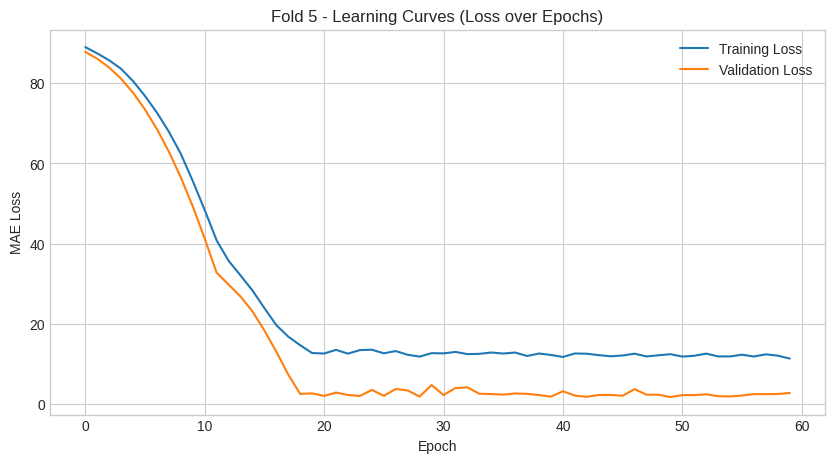

Fold 5 Result -> SBP MAE: 3.87, RMSE: 6.43 | DBP MAE: 1.83, RMSE: 3.50


In [77]:
# ===================================================================
# 5. 메인 실행 블록 (학습 및 평가) - 수정
# ===================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
try:
    X_data, Y_data = load_bp_data(PATIENT_FILE_PATH, mode=MODE, apply_filter=APPLY_BANDPASS_FILTER)
except (FileNotFoundError, ValueError) as e:
    print(e)

patient_id = os.path.basename(PATIENT_FILE_PATH).replace('.mat', '')
n_splits, fold_size = 5, 400
train_size, val_size, test_size = 320, 40, 40
fold_metrics, all_y_true, all_y_pred = [], [], []

if 'X_data' in locals():
    for i in range(n_splits):
        print(f"\n===== Fold {i+1}/{n_splits} Start =====")
        fold_start = i * fold_size
        train_end, val_end = fold_start + train_size, fold_start + train_size + val_size
        X_train, Y_train = X_data[fold_start:train_end], Y_data[fold_start:train_end]
        X_val, Y_val = X_data[train_end:val_end], Y_data[train_end:val_end]
        X_test, Y_test = X_data[val_end:fold_start+fold_size], Y_data[val_end:fold_start+fold_size]

        if APPLY_AUGMENTATION:
            print("Applying data augmentation...")
            X_train_aug = np.array([augment_signal(s) for s in X_train.squeeze()]).reshape(X_train.shape)
            Y_train_aug = Y_train
            X_train = np.concatenate([X_train, X_train_aug], axis=0)
            Y_train = np.concatenate([Y_train, Y_train_aug], axis=0)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(Y_train)), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_scaled).float(), torch.from_numpy(Y_val)), batch_size=BATCH_SIZE)

        # ===== 모델 선택 로직 수정 =====
        if MODEL_ARCHITECTURE == 'CNN_ONLY':
            model = Conv1DNet(input_channels=X_data.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
        elif MODEL_ARCHITECTURE == 'CNN_LSTM_ATTENTION':
            model = Conv1DLSTMNet(input_channels=X_data.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
        elif MODEL_ARCHITECTURE == 'CNN_TRANSFORMER':
            model = ConvTransformerNet(input_channels=X_data.shape[1], use_batch_norm=USE_BATCH_NORM).to(device)
        else:
            raise ValueError("MODEL_ARCHITECTURE를 'CNN_ONLY', 'CNN_LSTM_ATTENTION', 'CNN_TRANSFORMER' 중에서 선택하세요.")

        print(f"선택된 모델: {MODEL_ARCHITECTURE} (Batch Norm: {USE_BATCH_NORM})")

        criterion = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(NUM_EPOCHS):
            model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING_VALUE)
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    val_loss += criterion(model(inputs.to(device)), targets.to(device)).item()

            avg_val_loss = val_loss / len(val_loader)
            history['train_loss'].append(train_loss / len(train_loader))
            history['val_loss'].append(avg_val_loss)
            if USE_LR_SCHEDULER: scheduler.step(avg_val_loss)

        plot_learning_curves(history, fold_num=i+1)

        model.eval()
        with torch.no_grad():
            Y_pred_fold = model(torch.from_numpy(X_test_scaled).float().to(device)).cpu().numpy()

        sbp_mae, sbp_rmse = mean_absolute_error(Y_test[:, 0], Y_pred_fold[:, 0]), np.sqrt(mean_squared_error(Y_test[:, 0], Y_pred_fold[:, 0]))
        dbp_mae, dbp_rmse = mean_absolute_error(Y_test[:, 1], Y_pred_fold[:, 1]), np.sqrt(mean_squared_error(Y_test[:, 1], Y_pred_fold[:, 1]))

        fold_metrics.append({'sbp_mae': sbp_mae, 'sbp_rmse': sbp_rmse, 'dbp_mae': dbp_mae, 'dbp_rmse': dbp_rmse})
        all_y_true.append(Y_test), all_y_pred.append(Y_pred_fold)
        print(f"Fold {i+1} Result -> SBP MAE: {sbp_mae:.2f}, RMSE: {sbp_rmse:.2f} | DBP MAE: {dbp_mae:.2f}, RMSE: {dbp_rmse:.2f}")


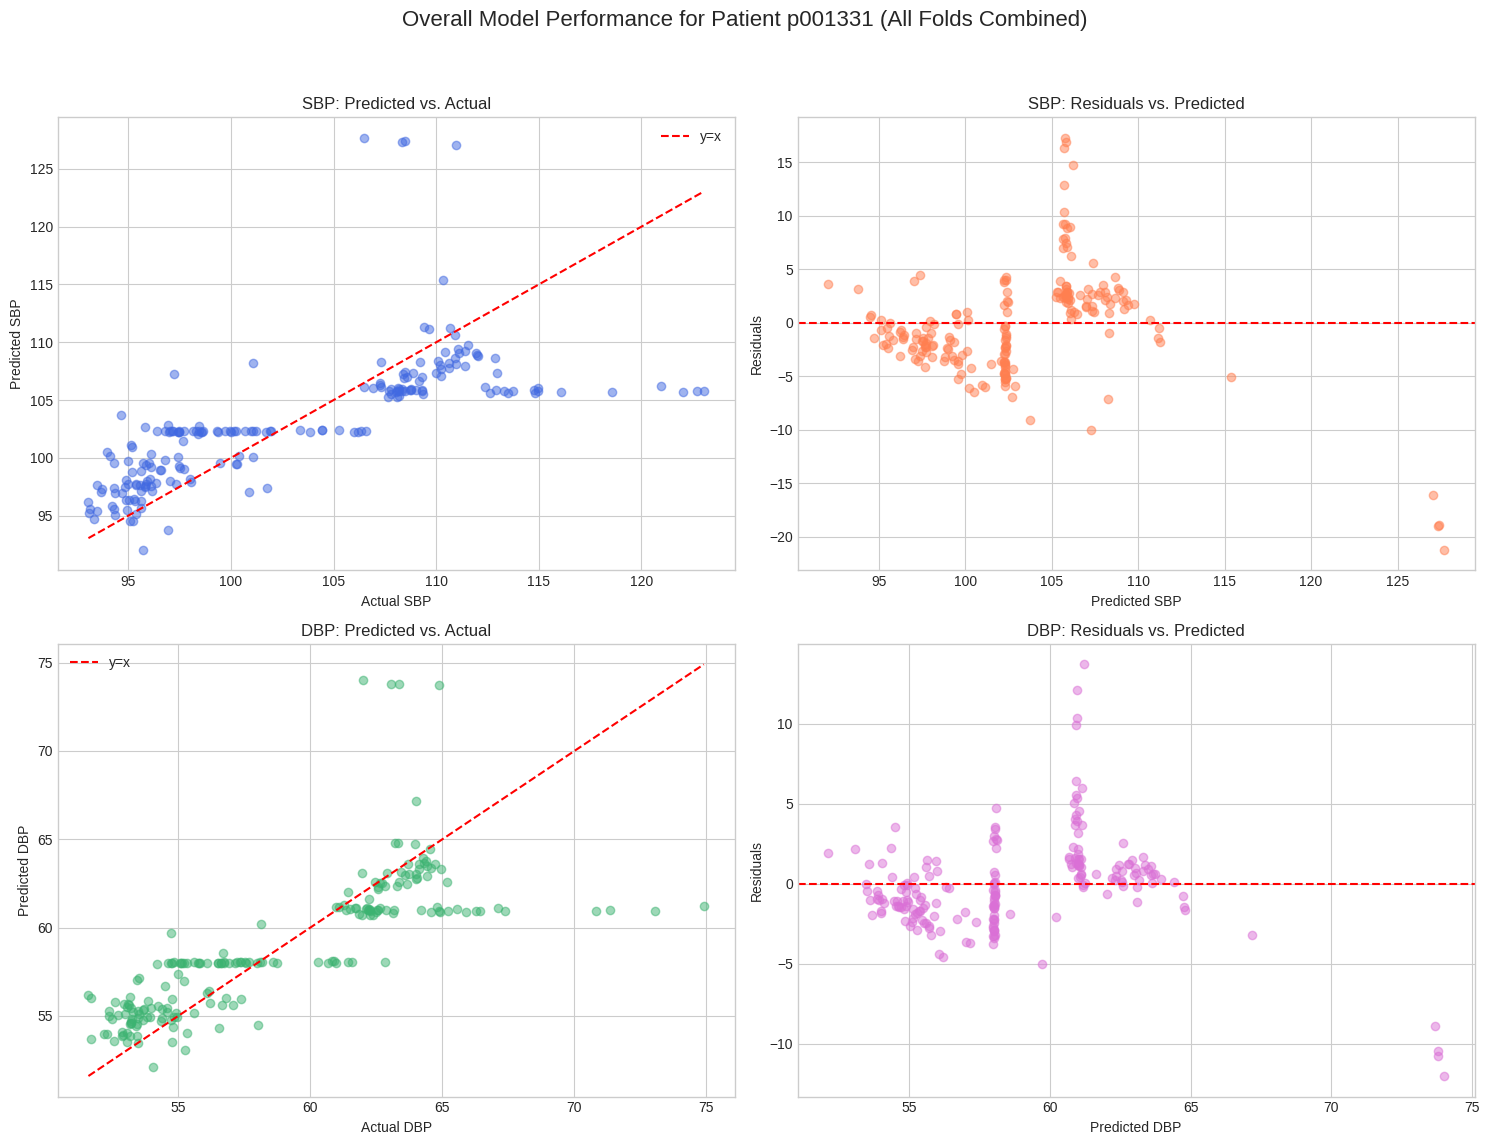


===== Final Results Summary =====
Patient: p001331, Mode: PPG_ECG, Model: CNN_TRANSFORMER, Filter: False, Augment: False, BN: True

--- Fold-wise Metrics ---
Fold 1: SBP MAE=2.65, RMSE=3.42 | DBP MAE=1.84, RMSE=2.17
Fold 2: SBP MAE=2.77, RMSE=3.36 | DBP MAE=1.49, RMSE=1.78
Fold 3: SBP MAE=3.21, RMSE=3.57 | DBP MAE=1.89, RMSE=2.22
Fold 4: SBP MAE=5.63, RMSE=7.31 | DBP MAE=3.23, RMSE=4.60
Fold 5: SBP MAE=3.87, RMSE=6.43 | DBP MAE=1.83, RMSE=3.50

--- Average Metrics (5-Fold) ---
SBP MAE : 3.63 ± 1.09
SBP RMSE: 4.82 ± 1.70
DBP MAE : 2.05 ± 0.60
DBP RMSE: 2.86 ± 1.05


In [78]:
# ===================================================================
# 6. 최종 결과 요약
# ===================================================================
if 'X_data' in locals() and all_y_true:
    final_y_true, final_y_pred = np.concatenate(all_y_true), np.concatenate(all_y_pred)
    plot_overall_regression_results(final_y_true, final_y_pred, patient_id)

    print("\n===== Final Results Summary =====")
    print(f"Patient: {patient_id}, Mode: {MODE}, Model: {MODEL_ARCHITECTURE}, Filter: {APPLY_BANDPASS_FILTER}, Augment: {APPLY_AUGMENTATION}, BN: {USE_BATCH_NORM}\n")
    print("--- Fold-wise Metrics ---")
    for i, m in enumerate(fold_metrics):
        print(f"Fold {i+1}: SBP MAE={m['sbp_mae']:.2f}, RMSE={m['sbp_rmse']:.2f} | DBP MAE={m['dbp_mae']:.2f}, RMSE={m['dbp_rmse']:.2f}")

    print("\n--- Average Metrics (5-Fold) ---")
    avg_sbp_mae, std_sbp_mae = np.mean([m['sbp_mae'] for m in fold_metrics]), np.std([m['sbp_mae'] for m in fold_metrics])
    avg_sbp_rmse, std_sbp_rmse = np.mean([m['sbp_rmse'] for m in fold_metrics]), np.std([m['sbp_rmse'] for m in fold_metrics])
    avg_dbp_mae, std_dbp_mae = np.mean([m['dbp_mae'] for m in fold_metrics]), np.std([m['dbp_mae'] for m in fold_metrics])
    avg_dbp_rmse, std_dbp_rmse = np.mean([m['dbp_rmse'] for m in fold_metrics]), np.std([m['dbp_rmse'] for m in fold_metrics])

    print(f"SBP MAE : {avg_sbp_mae:.2f} ± {std_sbp_mae:.2f}")
    print(f"SBP RMSE: {avg_sbp_rmse:.2f} ± {std_sbp_rmse:.2f}")
    print(f"DBP MAE : {avg_dbp_mae:.2f} ± {std_dbp_mae:.2f}")
    print(f"DBP RMSE: {avg_dbp_rmse:.2f} ± {std_dbp_rmse:.2f}")